In [1]:
import math
import numpy as np
from pydub import AudioSegment
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit,QuantumRegister, assemble, Aer
from qiskit.visualization import plot_histogram
from qiskit.compiler import transpile

/Users/ameyrodge/anaconda3/lib/python3.11/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Text(0, 0.5, 'amplitude')

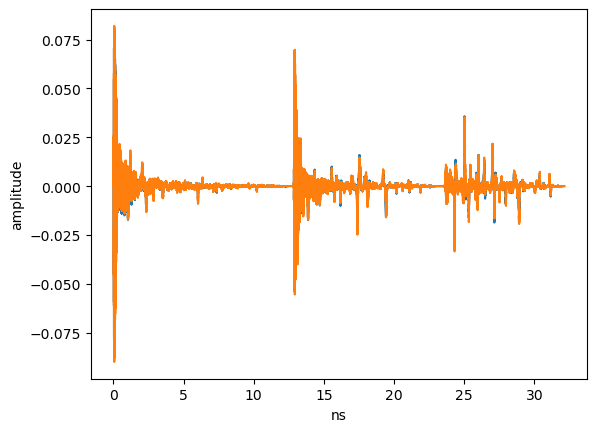

In [2]:
n_qubits = 10
import soundfile as sf
import sounddevice as sd
sample, fsp = sf.read('Audio_samples/GuitarLa.aif')
timeP = np.arange(len(sample)) / fsp
plt.plot(timeP, sample)
plt.xlabel('ns')
plt.ylabel('amplitude')

In [3]:
samples = sample[:2**n_qubits][:,1]
normalized_amplitudes = samples / np.linalg.norm(samples)
qc = QuantumCircuit(n_qubits)
samples

array([-4.76837158e-07,  8.34465027e-07,  2.26497650e-06, ...,
        8.56876373e-04,  8.41021538e-04,  8.72612000e-04])

/Users/ameyrodge/anaconda3/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


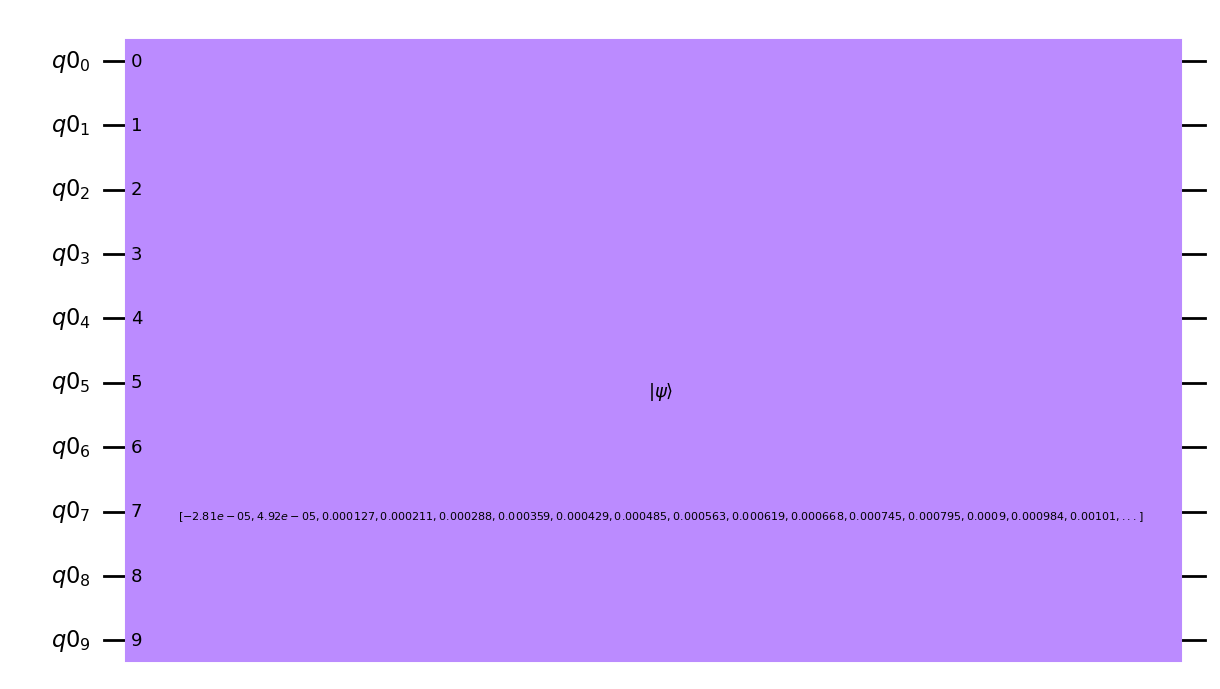

In [4]:
def create_encoded_qc(samples, n_qubits):
    q = QuantumRegister(n_qubits)
    qc = QuantumCircuit(q)

    # Ensure the length of samples is a power of 2
    samples = sample[:2**n_qubits][:,0]

    # Normalize the amplitudes
    normalized_amplitudes = samples / np.linalg.norm(samples)
    
    # Handle the case where all samples are zero
    if np.isnan(normalized_amplitudes).any():
        raise ValueError("All samples are zero. Unable to create a valid quantum state.")

    # Initialize the quantum circuit
    qc.initialize(normalized_amplitudes, [q[i] for i in range(n_qubits)])
    return qc
audio_qc = create_encoded_qc(samples, n_qubits)
audio_qc.draw('mpl')

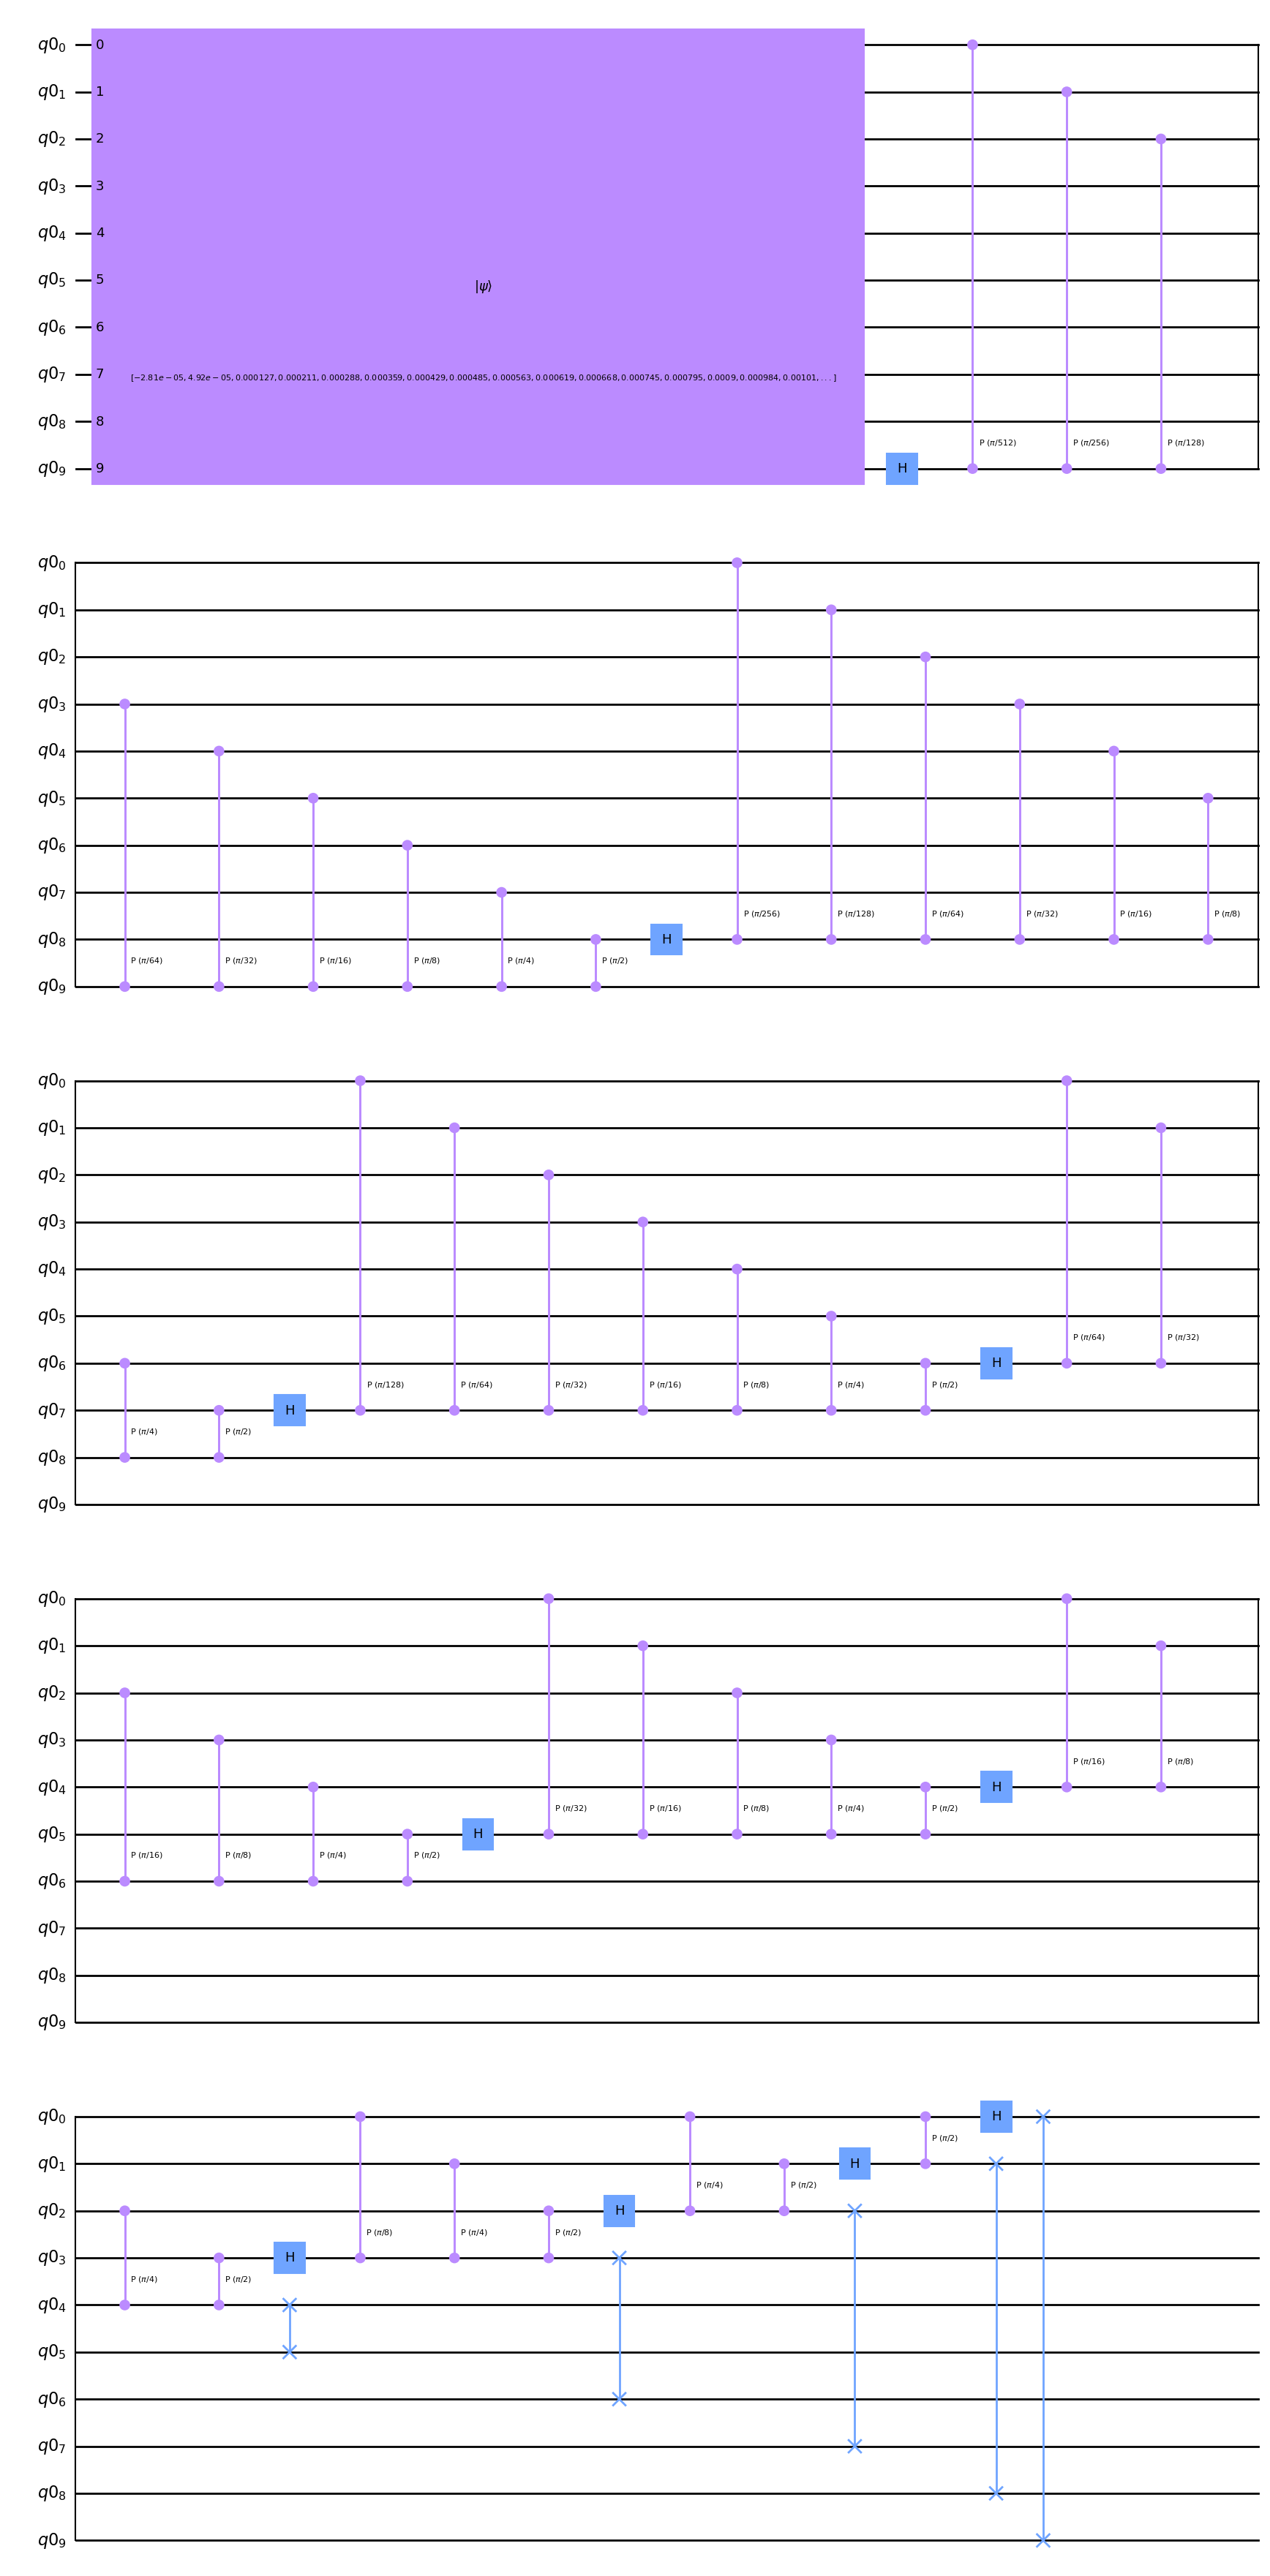

In [5]:
def qft_rotations(circuit, n):
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit


def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit
circuit =audio_qc
qft(circuit,n_qubits)
audio_qc.draw('mpl')

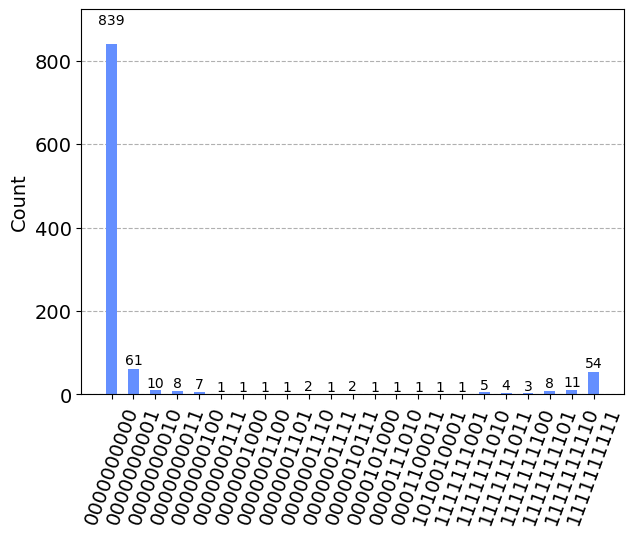

In [6]:
# Measuring all qubits
audio_qc.measure_all()


# Transpile the circuit
backend = Aer.get_backend("aer_simulator")
transpiled_qc = transpile(audio_qc, backend)

# Simulation
counts = backend.run(transpiled_qc).result().get_counts()

# Simple implementation for get_qft_counts
def get_qft_counts(counts, n_qubits):
    return [int(k, 2) for k in counts.keys()]

# Getting QFT counts
qft_counts = get_qft_counts(counts, n_qubits)[:len(samples)]

# Plotting the histogram
plot_histogram(counts)

In [10]:
# decoding the results
top_indices = np.argsort(-np.array(qft_counts[:3]))
freqs = top_indices*fsp/2**n_qubits
freqs

array([ 93.75, 187.5 ,   0.  ])